## Import Libraries

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

## Dataset

In [25]:
df = pd.read_csv('questions_answers.csv', sep='\t')

### Explore the dataset

In [26]:
df.head()

,question,reponse
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [27]:
df.shape

(3725, 2)

## Data Preprocessing

In [28]:
df['question tokens']=df['question'].apply(lambda x:len(x.split()))
df['reponse tokens']=df['reponse'].apply(lambda x:len(x.split()))

In [29]:
df

,question,reponse,question tokens,reponse tokens
0,"hi, how are you doing?",i'm fine. how about yourself?,5,5
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,5,6
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,6,7
3,no problem. so how have you been?,i've been great. what about you?,7,6
4,i've been great. what about you?,i've been good. i'm in school right now.,6,8
...,...,...,...,...
3720,that's a good question. maybe it's not old age.,are you right-handed?,9,3
3721,are you right-handed?,yes. all my life.,3,4
3722,yes. all my life.,you're wearing out your right hand. stop using...,4,11
3723,you're wearing out your right hand. stop using...,but i do all my writing with my right hand.,11,10


### Plot the number of tokens in each sentence

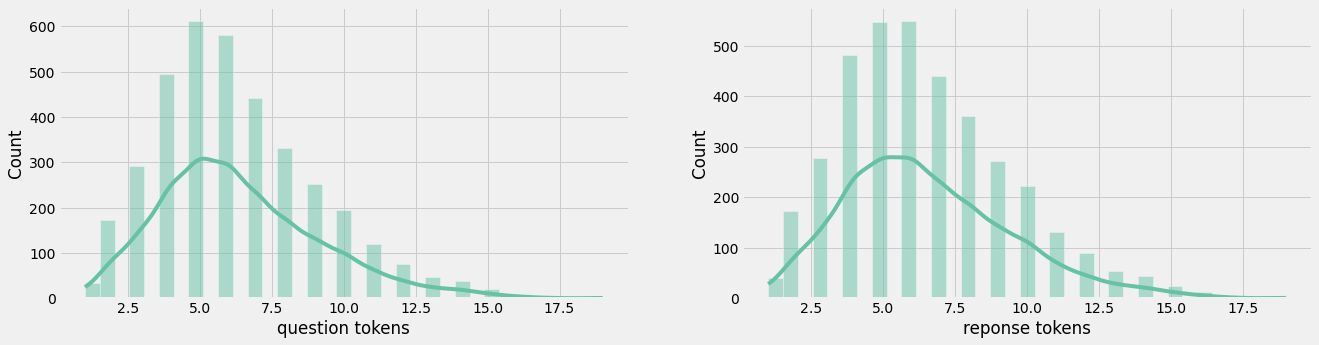

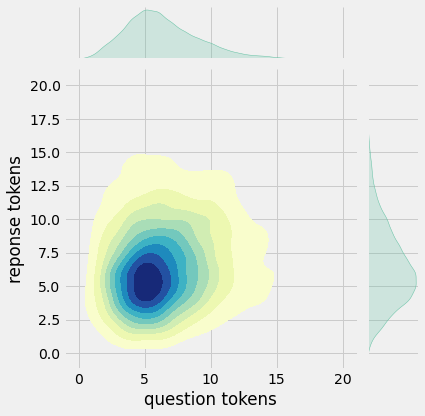

In [30]:
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['question tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['reponse tokens'],data=df,kde=True,ax=ax[1])
sns.jointplot(x='question tokens',y='reponse tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

### Clean the text

In [31]:
def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

In [32]:
# Dropping Unnecessary Columns
df.drop(columns=['reponse tokens','question tokens'],axis=1,inplace=True)
# Cleaning Text Data
df['encoder_inputs']=df['question'].apply(clean_text)
df['decoder_targets']=df['reponse'].apply(clean_text)+' <end>'
df['decoder_inputs']='<start> '+df['reponse'].apply(clean_text)+' <end>'

df.head(10)

,question,reponse,encoder_inputs,decoder_targets,decoder_inputs
0,"hi, how are you doing?",i'm fine. how about yourself?,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem. so how have you been?,i've been great. what about you?,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i've been great. what about you?,i've been good. i'm in school right now.,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i've been good. i'm in school right now.,what school do you go to?,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to?,i go to pcc.,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc.,do you like it there?,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there?,it's okay. it's a really big campus.,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it's okay. it's a really big campus.,good luck with school.,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


In [33]:
# Counting Tokens in Encoder, Decoder Inputs & Decoder Targets
df['encoder input tokens']=df['encoder_inputs'].apply(lambda x:len(x.split()))
df['decoder input tokens']=df['decoder_inputs'].apply(lambda x:len(x.split()))
df['decoder target tokens']=df['decoder_targets'].apply(lambda x:len(x.split()))

### Visualizes token distributions in questions and responses, and their density relationship.

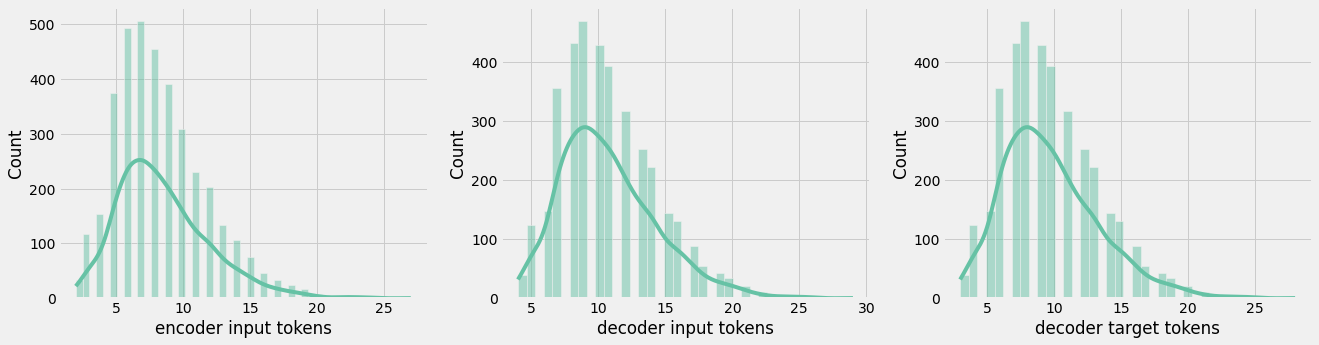

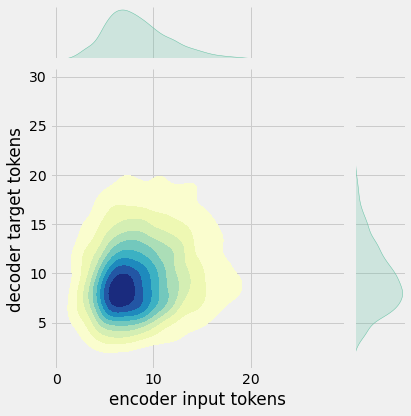

In [34]:
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['encoder input tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['decoder input tokens'],data=df,kde=True,ax=ax[1])
sns.histplot(x=df['decoder target tokens'],data=df,kde=True,ax=ax[2])
sns.jointplot(x='encoder input tokens',y='decoder target tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [35]:
print(f"After preprocessing: {' '.join(df[df['encoder input tokens'].max()==df['encoder input tokens']]['encoder_inputs'].values.tolist())}")
print(f"Max encoder input length: {df['encoder input tokens'].max()}")
print(f"Max decoder input length: {df['decoder input tokens'].max()}")
print(f"Max decoder target length: {df['decoder target tokens'].max()}")

df.drop(columns=['question','reponse','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)

After preprocessing: for example ,  if your birth date is january  1  2  ,   1  9  8  7  ,  write  0  1  /  1  2  /  8  7  . 
Max encoder input length: 27
Max decoder input length: 29
Max decoder target length: 28


In [36]:
# Model Parameters & Hyperparameters with LSTM
params={
    "vocab_size":2500,
    "max_sequence_length":30,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']

In [37]:
df.head(10)

,encoder_inputs,decoder_targets,decoder_inputs
0,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


## Tokenization

### Configures text vectorization, adapting it to both inputs and targets, and displays the updated vocabulary size and top tokens.

In [38]:
vectorize_layer=TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(df['encoder_inputs']+' '+df['decoder_targets']+' <start> <end>')
vocab_size=len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {len(vectorize_layer.get_vocabulary())}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 2443
['', '[UNK]', '<end>', '.', '<start>', "'", 'i', '?', 'you', ',', 'the', 'to']


### Converts text to IDs and back, showcasing shapes of model inputs and outputs.

In [39]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x=sequences2ids(df['encoder_inputs'])
yd=sequences2ids(df['decoder_inputs'])
y=sequences2ids(df['decoder_targets'])

print(f'Question sentence: Qui sont les personnes qui travaillent la terre ?')
print(f'Question to tokens: {sequences2ids("Qui sont les personnes qui travaillent la terre ?")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Question sentence: Qui sont les personnes qui travaillent la terre ?
Question to tokens: [1 1 1 1 1 1 1 1 7 0]
Encoder input shape: (3725, 30)
Decoder input shape: (3725, 30)
Decoder target shape: (3725, 30)


In [40]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [1971    9   45   24    8  194    7    0    0    0    0    0] ...
Decoder input: [  4   6   5  38 646   3  45  41 563   7   2   0] ...
Decoder target: [  6   5  38 646   3  45  41 563   7   2   0   0] ...


### Prepares training and validation datasets, details data batching and shapes.

In [41]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 23
Number of training data: 3427
Number of validation batches: 3
Number of validation data: 447
Encoder Input shape (with batches): (149, 30)
Decoder Input shape (with batches): (149, 30)
Target Output shape (with batches): (149, 30)


## Build Models

### Build Encoder

### Defines an Encoder class for a Seq2Seq model, embedding inputs and processing them through LSTM.

In [42]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )
    
    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.00365355, -0.10150773,  0.02193609, ..., -0.17392603,
         -0.04627816,  0.13783707],
        [-0.16027111, -0.09598479, -0.07460954, ..., -0.03273502,
         -0.23657407, -0.13044526],
        [-0.01570487, -0.04228086, -0.06129317, ..., -0.10733669,
         -0.02184573,  0.00722946],
        ...,
        [-0.18475197, -0.07738408, -0.07749932, ..., -0.15452863,
         -0.28452682, -0.02481479],
        [-0.19978301,  0.07585975,  0.17388311, ...,  0.11342715,
         -0.11611998,  0.05492564],
        [ 0.01447767, -0.06803377, -0.06786793, ..., -0.03559692,
          0.01125973, -0.01029266]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.01016357, -0.288562  ,  0.05352268, ..., -0.26314175,
         -0.08510429,  0.34197968],
        [-0.3280071 , -0.14012054, -0.19538572, ..., -0.05819339,
         -0.3977765 , -0.26602048],
        [-0.04150655, -0.1179687 , -0.15023732,

### Build Decoder

### Implements a Decoder class with embedding, LSTM, and dense layers, integrating encoder states for Seq2Seq processing.

In [43]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
    
    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 30, 2443), dtype=float32, numpy=
array([[[1.0275231e-04, 1.3377893e-05, 4.2974515e-04, ...,
         7.4073512e-05, 1.7822610e-04, 9.1411290e-05],
        [1.6117885e-05, 3.0563162e-05, 1.4018206e-04, ...,
         9.0525784e-05, 3.0547660e-04, 1.7171068e-04],
        [9.7866869e-06, 7.8508907e-05, 3.6104574e-04, ...,
         9.9273006e-05, 3.0107509e-05, 2.7374731e-04],
        ...,
        [3.2067139e-05, 2.3081418e-05, 6.8208080e-04, ...,
         6.1513914e-05, 5.6304951e-05, 3.4676370e-05],
        [3.2067124e-05, 2.3081418e-05, 6.8208080e-04, ...,
         6.1513914e-05, 5.6304951e-05, 3.4676370e-05],
        [3.2067124e-05, 2.3081418e-05, 6.8208080e-04, ...,
         6.1513914e-05, 5.6304951e-05, 3.4676370e-05]]], dtype=float32)>

### Build Training Model

### Integrates Encoder and Decoder into a ChatBotTrainer model, including custom training, testing, and metric evaluation logic.

In [44]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)
    
    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    
    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

### Configures and compiles the ChatBotTrainer model for training, setting up loss function, optimizer, and metrics.

In [45]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 30, 2443), dtype=float32, numpy=
array([[[1.02752412e-04, 1.33779013e-05, 4.29744978e-04, ...,
         7.40734831e-05, 1.78226197e-04, 9.14111661e-05],
        [1.61178887e-05, 3.05631547e-05, 1.40182092e-04, ...,
         9.05258930e-05, 3.05476802e-04, 1.71710562e-04],
        [9.78668504e-06, 7.85088923e-05, 3.61045502e-04, ...,
         9.92731293e-05, 3.01075033e-05, 2.73746991e-04],
        ...,
        [3.20671897e-05, 2.30814312e-05, 6.82080572e-04, ...,
         6.15139215e-05, 5.63048998e-05, 3.46763700e-05],
        [3.20671897e-05, 2.30814312e-05, 6.82080572e-04, ...,
         6.15139215e-05, 5.63048998e-05, 3.46763700e-05],
        [3.20671897e-05, 2.30814312e-05, 6.82080572e-04, ...,
         6.15139215e-05, 5.63048998e-05, 3.46763700e-05]],

       [[8.84755354e-05, 1.23044461e-04, 6.16221165e-04, ...,
         1.33030670e-04, 4.45328405e-05, 1.76798087e-04],
        [7.64103897e-05, 1.52841691e-04, 1.76198679e-04, ...,
         4.77359354e-05, 8

## Train Model

In [46]:
history=model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/100


23/23 [==============================] - ETA: 0s - loss: 1.6610 - accuracy: 0.2192
Epoch 1: val_loss improved from inf to 1.31637, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 50s 2s/step - loss: 1.6531 - accuracy: 0.2218 - val_loss: 1.3164 - val_accuracy: 0.2763
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 1.2367 - accuracy: 0.3100
Epoch 2: val_loss improved from 1.31637 to 1.24300, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 41s 2s/step - loss: 1.2326 - accuracy: 0.3114 - val_loss: 1.2430 - val_accuracy: 0.3008
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 1.1091 - accuracy: 0.3365
Epoch 3: val_loss improved from 1.24300 to 0.99598, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 51s 2s/step - loss: 1.1119 - accuracy: 0.3362 - val_loss: 0.9960 - val_accuracy: 0.3545
Epoch 4/100
23/23 [==============================] - ETA: 0s - loss: 1.0274 - accuracy: 0.3547
Epoch 4: val_loss improved from 0.99598 to 0.98873, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 69s 3s/step - loss: 1.0277 - accuracy: 0.3544 - val_loss: 0.9887 - val_accuracy: 0.3601
Epoch 5/100
23/23 [==============================] - ETA: 0s - loss: 0.9673 - accuracy: 0.3680
Epoch 5: val_loss improved from 0.98873 to 0.83160, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 64s 3s/step - loss: 0.9666 - accuracy: 0.3691 - val_loss: 0.8316 - val_accuracy: 0.4089
Epoch 6/100
23/23 [==============================] - ETA: 0s - loss: 0.9223 - accuracy: 0.3776
Epoch 6: val_loss did not improve from 0.83160
23/23 [==============================] - 41s 2s/step - loss: 0.9230 - accuracy: 0.3779 - val_loss: 0.9585 - val_accuracy: 0.3872
Epoch 7/100
23/23 [==============================] - ETA: 0s - loss: 0.8782 - accuracy: 0.3937
Epoch 7: val_loss did not improve from 0.83160
23/23 [==============================] - 40s 2s/step - loss: 0.8776 - accuracy: 0.3945 - val_loss: 0.9522 - val_accuracy: 0.3928
Epoch 8/100
23/23 [==============================] - ETA: 0s - loss: 0.8468 - accuracy: 0.4023
Epoch 8: val_loss did not improve from 0.83160
23/23 [==============================] - 41s 2s/step - loss: 0.8472 - accuracy: 0.4031 - val_loss: 0.8918 - val_accuracy: 0.4119
Epoch 9/100
23/23 [==============================] - ETA: 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 63s 3s/step - loss: 0.8247 - accuracy: 0.4063 - val_loss: 0.7101 - val_accuracy: 0.4436
Epoch 10/100
23/23 [==============================] - ETA: 0s - loss: 0.7957 - accuracy: 0.4192
Epoch 10: val_loss improved from 0.71009 to 0.70313, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 59s 3s/step - loss: 0.7975 - accuracy: 0.4185 - val_loss: 0.7031 - val_accuracy: 0.4615
Epoch 11/100
23/23 [==============================] - ETA: 0s - loss: 0.7694 - accuracy: 0.4295
Epoch 11: val_loss did not improve from 0.70313
23/23 [==============================] - 45s 2s/step - loss: 0.7709 - accuracy: 0.4292 - val_loss: 0.8631 - val_accuracy: 0.4105
Epoch 12/100
23/23 [==============================] - ETA: 0s - loss: 0.7537 - accuracy: 0.4342
Epoch 12: val_loss did not improve from 0.70313
23/23 [==============================] - 45s 2s/step - loss: 0.7567 - accuracy: 0.4340 - val_loss: 0.8040 - val_accuracy: 0.4529
Epoch 13/100
23/23 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.4435
Epoch 13: val_loss did not improve from 0.70313
23/23 [==============================] - 45s 2s/step - loss: 0.7341 - accuracy: 0.4430 - val_loss: 0.7322 - val_accuracy: 0.4619
Epoch 14/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 69s 3s/step - loss: 0.7023 - accuracy: 0.4562 - val_loss: 0.6791 - val_accuracy: 0.4579
Epoch 16/100
23/23 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.4625
Epoch 16: val_loss improved from 0.67906 to 0.61305, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 68s 3s/step - loss: 0.6852 - accuracy: 0.4609 - val_loss: 0.6130 - val_accuracy: 0.4970
Epoch 17/100
23/23 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.4704
Epoch 17: val_loss did not improve from 0.61305
23/23 [==============================] - 41s 2s/step - loss: 0.6716 - accuracy: 0.4694 - val_loss: 0.7222 - val_accuracy: 0.4876
Epoch 18/100
23/23 [==============================] - ETA: 0s - loss: 0.6581 - accuracy: 0.4761
Epoch 18: val_loss did not improve from 0.61305
23/23 [==============================] - 40s 2s/step - loss: 0.6587 - accuracy: 0.4754 - val_loss: 0.7310 - val_accuracy: 0.4930
Epoch 19/100
23/23 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.4859
Epoch 19: val_loss did not improve from 0.61305
23/23 [==============================] - 41s 2s/step - loss: 0.6439 - accuracy: 0.4856 - val_loss: 0.7973 - val_accuracy: 0.4407
Epoch 20/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 64s 3s/step - loss: 0.6324 - accuracy: 0.4875 - val_loss: 0.6095 - val_accuracy: 0.4839
Epoch 21/100
23/23 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.4948
Epoch 21: val_loss did not improve from 0.60954
23/23 [==============================] - 49s 2s/step - loss: 0.6227 - accuracy: 0.4933 - val_loss: 0.6586 - val_accuracy: 0.4934
Epoch 22/100
23/23 [==============================] - ETA: 0s - loss: 0.6111 - accuracy: 0.5008
Epoch 22: val_loss did not improve from 0.60954
23/23 [==============================] - 48s 2s/step - loss: 0.6136 - accuracy: 0.5005 - val_loss: 0.6130 - val_accuracy: 0.5205
Epoch 23/100
23/23 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.5057
Epoch 23: val_loss improved from 0.60954 to 0.55420, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 72s 3s/step - loss: 0.6037 - accuracy: 0.5057 - val_loss: 0.5542 - val_accuracy: 0.5189
Epoch 24/100
23/23 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.5121
Epoch 24: val_loss did not improve from 0.55420
23/23 [==============================] - 42s 2s/step - loss: 0.5937 - accuracy: 0.5108 - val_loss: 0.7027 - val_accuracy: 0.4973
Epoch 25/100
23/23 [==============================] - ETA: 0s - loss: 0.5871 - accuracy: 0.5164
Epoch 25: val_loss did not improve from 0.55420
23/23 [==============================] - 41s 2s/step - loss: 0.5882 - accuracy: 0.5158 - val_loss: 0.6557 - val_accuracy: 0.4775
Epoch 26/100
23/23 [==============================] - ETA: 0s - loss: 0.5794 - accuracy: 0.5190
Epoch 26: val_loss did not improve from 0.55420
23/23 [==============================] - 42s 2s/step - loss: 0.5819 - accuracy: 0.5176 - val_loss: 0.6398 - val_accuracy: 0.5228
Epoch 27/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 65s 3s/step - loss: 0.5407 - accuracy: 0.5392 - val_loss: 0.5048 - val_accuracy: 0.5378
Epoch 32/100
23/23 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.5423
Epoch 32: val_loss did not improve from 0.50482
23/23 [==============================] - 46s 2s/step - loss: 0.5409 - accuracy: 0.5412 - val_loss: 0.5178 - val_accuracy: 0.5516
Epoch 33/100
23/23 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.5498
Epoch 33: val_loss did not improve from 0.50482
23/23 [==============================] - 46s 2s/step - loss: 0.5309 - accuracy: 0.5490 - val_loss: 0.6606 - val_accuracy: 0.5223
Epoch 34/100
23/23 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.5510
Epoch 34: val_loss did not improve from 0.50482
23/23 [==============================] - 47s 2s/step - loss: 0.5219 - accuracy: 0.5494 - val_loss: 0.5246 - val_accuracy: 0.5458
Epoch 35/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 69s 3s/step - loss: 0.4992 - accuracy: 0.5691 - val_loss: 0.4953 - val_accuracy: 0.5751
Epoch 40/100
23/23 [==============================] - ETA: 0s - loss: 0.4923 - accuracy: 0.5703
Epoch 40: val_loss did not improve from 0.49531
23/23 [==============================] - 50s 2s/step - loss: 0.4923 - accuracy: 0.5699 - val_loss: 0.5950 - val_accuracy: 0.5517
Epoch 41/100
23/23 [==============================] - ETA: 0s - loss: 0.4865 - accuracy: 0.5738
Epoch 41: val_loss did not improve from 0.49531
23/23 [==============================] - 48s 2s/step - loss: 0.4866 - accuracy: 0.5743 - val_loss: 0.5347 - val_accuracy: 0.5649
Epoch 42/100
23/23 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.5811
Epoch 42: val_loss did not improve from 0.49531
23/23 [==============================] - 49s 2s/step - loss: 0.4838 - accuracy: 0.5794 - val_loss: 0.5870 - val_accuracy: 0.5607
Epoch 43/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 82s 4s/step - loss: 0.4700 - accuracy: 0.5883 - val_loss: 0.4830 - val_accuracy: 0.5746
Epoch 46/100
23/23 [==============================] - ETA: 0s - loss: 0.4717 - accuracy: 0.5859
Epoch 46: val_loss did not improve from 0.48301
23/23 [==============================] - 52s 2s/step - loss: 0.4738 - accuracy: 0.5856 - val_loss: 0.4835 - val_accuracy: 0.5768
Epoch 47/100
23/23 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.5919
Epoch 47: val_loss did not improve from 0.48301
23/23 [==============================] - 55s 2s/step - loss: 0.4623 - accuracy: 0.5914 - val_loss: 0.5603 - val_accuracy: 0.5556
Epoch 48/100
23/23 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.5933
Epoch 48: val_loss did not improve from 0.48301
23/23 [==============================] - 54s 2s/step - loss: 0.4573 - accuracy: 0.5933 - val_loss: 0.5045 - val_accuracy: 0.6000
Epoch 49/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 86s 4s/step - loss: 0.4115 - accuracy: 0.6282 - val_loss: 0.4353 - val_accuracy: 0.6121
Epoch 64/100
23/23 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.6273
Epoch 64: val_loss improved from 0.43530 to 0.40937, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 83s 4s/step - loss: 0.4101 - accuracy: 0.6268 - val_loss: 0.4094 - val_accuracy: 0.6350
Epoch 65/100
23/23 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.6279
Epoch 65: val_loss did not improve from 0.40937
23/23 [==============================] - 59s 3s/step - loss: 0.4073 - accuracy: 0.6278 - val_loss: 0.4628 - val_accuracy: 0.6048
Epoch 66/100
23/23 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.6320
Epoch 66: val_loss did not improve from 0.40937
23/23 [==============================] - 62s 3s/step - loss: 0.4020 - accuracy: 0.6324 - val_loss: 0.5570 - val_accuracy: 0.6095
Epoch 67/100
23/23 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.6352
Epoch 67: val_loss did not improve from 0.40937
23/23 [==============================] - 63s 3s/step - loss: 0.3988 - accuracy: 0.6360 - val_loss: 0.4302 - val_accuracy: 0.6351
Epoch 68/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 82s 4s/step - loss: 0.3587 - accuracy: 0.6651 - val_loss: 0.3754 - val_accuracy: 0.6723
Epoch 90/100
23/23 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.6628
Epoch 90: val_loss did not improve from 0.37540
23/23 [==============================] - 59s 3s/step - loss: 0.3588 - accuracy: 0.6611 - val_loss: 0.4760 - val_accuracy: 0.6217
Epoch 91/100
23/23 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.6645
Epoch 91: val_loss did not improve from 0.37540
23/23 [==============================] - 59s 3s/step - loss: 0.3577 - accuracy: 0.6635 - val_loss: 0.4119 - val_accuracy: 0.6615
Epoch 92/100
23/23 [==============================] - ETA: 0s - loss: 0.3550 - accuracy: 0.6658
Epoch 92: val_loss did not improve from 0.37540
23/23 [==============================] - 62s 3s/step - loss: 0.3560 - accuracy: 0.6651 - val_loss: 0.4701 - val_accuracy: 0.6332
Epoch 93/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 85s 4s/step - loss: 0.3456 - accuracy: 0.6736 - val_loss: 0.3611 - val_accuracy: 0.6897


## Visualize Metrics

In [47]:
# Printing the model summary
model.summary()

Model: "chatbot_trainer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1151232   
                                                                 
 decoder (Decoder)           multiple                  1779083   
                                                                 
Total params: 2,930,315
Trainable params: 2,930,315
Non-trainable params: 0
_________________________________________________________________


### Visualizes training loss and accuracy metrics over epochs, comparing performance on both training and validation data.

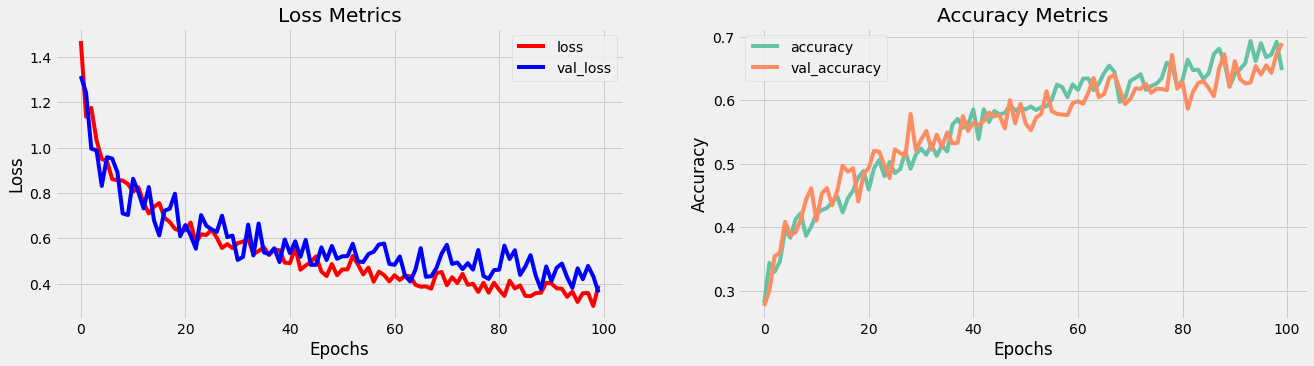

In [48]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

## Save Model

In [50]:
import os

cwd = os.getcwd()

# model.load_weights(cwd+'/ckpt')
model.save('models',save_format='tf')

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


### Enumerates and prints the layers within the Encoder and Decoder components of the ChatBotTrainer model, providing a structured overview.

In [51]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('---------------------')

Encoder layers:
---------------------
Decoder layers: 
---------------------


## Create Inference Model

### Builds an Inference model for the ChatBot, using the trained Encoder and Decoder models to predict responses.

In [52]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

In [53]:
chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddin  (None, None, 256)        625408    
 g)                                                              
                                                                 
 layer_normalization_2 (Laye  (None, None, 256)        512       
 rNormalization)                                                 
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1,151,232
Trainable params: 1,151,232

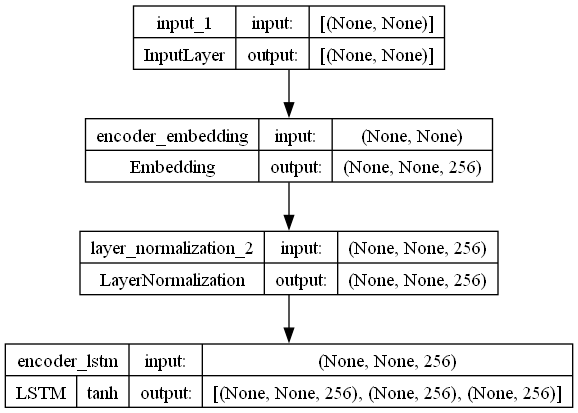

In [54]:
tf.keras.utils.plot_model(chatbot.encoder,to_file='encoder.png',show_shapes=True,show_layer_activations=True)

## Test ChatBot

In [55]:
def print_conversation(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chatbot(text)}')
        print('========================')

In [57]:
print_conversation([
    'hi, how are you doing?	',
    'yes, I am doing great',
    'what is your name?',
    'are you a human or a bot?',
    'what is your favorite color?',
    'what is your favorite food?',
    'what is your favorite movie?',
])

You: hi, how are you doing?	
Bot: i'm fine. how about you? 
You: yes, I am doing great
Bot: you're not the going to go to the bathroom. 
You: what is your name?
Bot: it's a yearly reminder to take care of our planet. 
You: are you a human or a bot?
Bot: yes, i did. a site i have a pen. 
You: what is your favorite color?
Bot: i have to do something tomorrow. 
You: what is your favorite food?
Bot: i'm not sure. 
You: what is your favorite movie?
Bot: my favorite movie is superbad. 
